# 03. RAG Evaluation (LLM-as-a-Judge)

In this notebook, we will evaluate the quality of our RAG pipeline using the **LLM-as-a-Judge** paradigm.
We will use the Gemma 2 model itself to evaluate its own outputs (or outputs from the pipeline) based on two key metrics:

1.  **Faithfulness**: Is the answer derived *solely* from the retrieved context?
2.  **Answer Relevance**: Does the answer directly address the user's question?

We will score these on a scale of 1-5.

In [1]:
# ==========================================
# 1. Global Setup & Imports
# ==========================================
import os
import sys
import gc
import torch
import pandas as pd
import tqdm
import tqdm.auto
import tqdm.notebook
import tqdm.std
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import Project Modules
import src.rag
import src.visualization
import src.evaluation 
import src.generation
from src.rag import RAGPipeline
from src.visualization import set_plot_style

# Force standard text-based progress bar
tqdm.tqdm = tqdm.std.tqdm
tqdm.auto.tqdm = tqdm.std.tqdm
tqdm.notebook.tqdm = tqdm.std.tqdm

# Reload modules to ensure latest logic
importlib.reload(src.rag)
importlib.reload(src.visualization)
importlib.reload(src.evaluation)
importlib.reload(src.generation)

# Set plot style
set_plot_style()

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ==========================================
# 2. Initialize RAG Pipeline
# ==========================================
# Clean up memory to avoid OOM if re-running
print("Cleaning up memory...")
try:
    del rag
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

# Initialize Pipeline
print(f"Initializing RAG Pipeline on {device}...")
rag = RAGPipeline(device=device)
rag.load_resources()

# Verify model placement
print(f"Model device map: {rag.model.hf_device_map if hasattr(rag.model, 'hf_device_map') else rag.model.device}")

Cleaning up memory...
Initializing RAG Pipeline on cuda...
--- Loading RAG Resources on CUDA ---
Loading Knowledge Base from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\knowledge_base.parquet
Loading FAISS Index from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\faiss_index.bin
Loading Embedding Model: all-MiniLM-L6-v2
Loading LLM: google/gemma-2-2b-it


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


All resources loaded successfully.

Model device map: {'': device(type='cuda')}


# Section 1: Data Generation

We generate a synthetic test set of **200 queries** based on the medical dataset. 
The generation process includes validation to ensure questions are actually answerable from the context.

In [3]:
# ==========================================
# 3. Generate Synthetic Test Set
# ==========================================
# Configuration
FORCE_GENERATE_QUERIES = True 
queries_path = '../output/generated_test_queries.csv'

# Generate or Load Queries
eval_queries_df = src.generation.generate_synthetic_queries(
    rag, 
    num_queries=195, 
    output_path=queries_path, 
    seed=42, 
    force=FORCE_GENERATE_QUERIES
)

# Extract questions list
if isinstance(eval_queries_df, pd.DataFrame):
    eval_queries = eval_queries_df['question'].tolist()
else:
    eval_queries = eval_queries_df

# Filter out garbage queries
print(f"Initial queries loaded: {len(eval_queries)}")
original_count = len(eval_queries)

filtered_queries = [
    q for q in eval_queries 
    if q.strip().endswith('?') 
    and not q.strip().startswith('*') 
    and not q.strip().startswith('Explanation:')
    and len(q.strip()) > 15
]

eval_queries = filtered_queries
print(f"Filtered out {original_count - len(eval_queries)} garbage queries.")
print(f"Remaining queries for evaluation: {len(eval_queries)}")

# Save Cleaned Queries for Inspection
clean_queries_path = '../output/clean_test_queries.txt'
with open(clean_queries_path, 'w', encoding='utf-8') as f:
    for i, q in enumerate(eval_queries, 1):
        f.write(f"{i}. {q}\n")

print(f"Cleaned queries saved to: {clean_queries_path}")

Generating 195 synthetic questions from the Knowledge Base...
Using document-level generation (grouping chunks by original_id)...


Gen Valid Queries: 100%|######################| 195/195 [04:26<00:00,  1.36s/it]

Generated 200 queries (including OOD).
Queries saved to ../output/generated_test_queries.csv
Detailed report saved to ../output/generated_test_queries_detailed_detailed.txt
Initial queries loaded: 200
Filtered out 1 garbage queries.
Remaining queries for evaluation: 199
Cleaned queries saved to: ../output/clean_test_queries.txt


# Section 2: Execution (LLM-as-a-Judge)

We run the evaluation on two scenarios:
1.  **RAG + Abstain**: The full pipeline.
2.  **No RAG (LLM Only)**: The model answering from its internal weights.

The results are saved to `output/evaluation_results_full.csv`.

In [4]:
# ==========================================
# 4. Run Comprehensive Evaluation
# ==========================================
# Configuration
FORCE_RUN_EVALUATION = True 
results_path = '../output/evaluation_results_full.csv'
detailed_output_path = '../output/detailed_evaluation_analysis.txt'

# Check if we should skip execution
if not FORCE_RUN_EVALUATION and os.path.exists(results_path):
    print(f"Found existing results at {results_path}. Skipping re-evaluation.")
    results_df = pd.read_csv(results_path)
else:
    # Get queries and contexts
    if isinstance(eval_queries_df, pd.DataFrame):
        queries = eval_queries_df['question'].tolist()
        contexts = eval_queries_df['source_context'].tolist()
    else:
        queries = eval_queries
        contexts = ["(Context not available)"] * len(queries)

    print(f"FULL MODE: Running on all {len(queries)} queries.")
    
    # Run evaluation
    results_df = src.evaluation.run_comprehensive_evaluation(
        rag, 
        queries, 
        contexts, 
        detailed_output_path, 
        results_path
    )

FULL MODE: Running on all 200 queries.
Starting Detailed Evaluation on 200 queries...
Detailed report will be saved to: ../output/detailed_evaluation_analysis.txt


Evaluating: 100%|██████████| 200/200 [1:29:40<00:00, 26.90s/it]

Results saved to ../output/evaluation_results_full.csv


# Section 3: Quantitative Analysis

We analyze the results using:
1.  **ROUGE Scores**: Lexical overlap with ground truth context.
2.  **Faithfulness & Relevance**: LLM-judged metrics.
3.  **Abstention Rates**: How often the model refuses to answer.

Calculating ROUGE scores for 566 valid answers...

Generating ROUGE Score Plot...

ROUGE-L Stats (Answer vs. Context):
            Scenario      mean       sem  count       std
0  No RAG (LLM Only)  0.156577  0.003462    200  0.048957
1   RAG (No Abstain)  0.160243  0.008152    200  0.115281
2      RAG + Abstain  0.170785  0.009186    166  0.118355
Plot saved to: ../output\rouge_scores.png


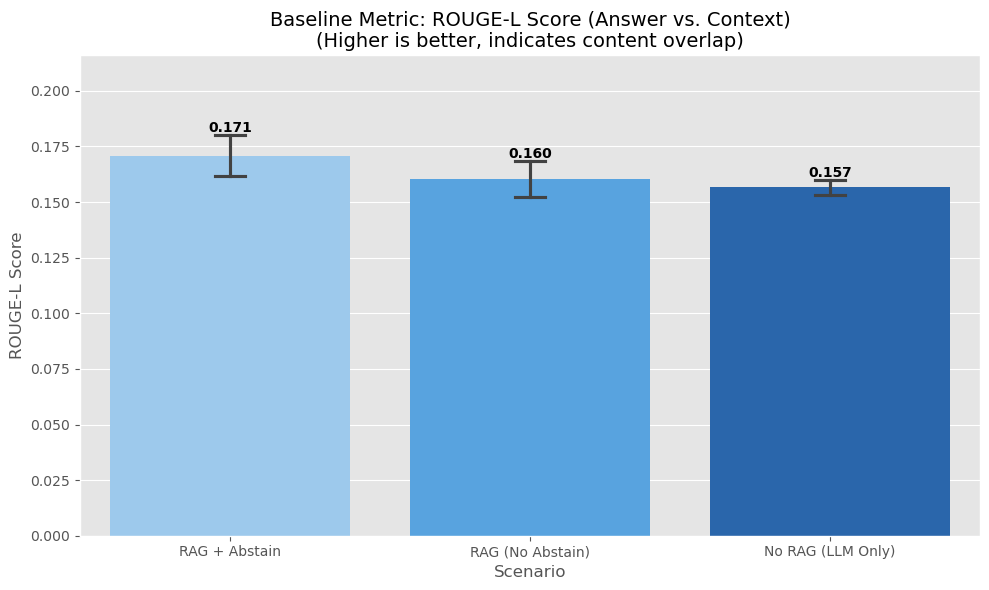

In [5]:
# ==========================================
# 5. ROUGE Score Analysis
# ==========================================
# Load Context Map
context_map = {}
if 'eval_queries_df' in locals() and isinstance(eval_queries_df, pd.DataFrame):
    context_map = dict(zip(eval_queries_df['question'], eval_queries_df['source_context']))
elif os.path.exists(queries_path):
    queries_df = pd.read_csv(queries_path)
    context_map = dict(zip(queries_df['question'], queries_df['source_context']))

# Calculate ROUGE
valid_results = src.evaluation.calculate_rouge_scores(results_df, context_map)

# Plot ROUGE
if not valid_results.empty:
    print("\nGenerating ROUGE Score Plot...")
    src.visualization.plot_rouge_scores(valid_results, save_path='../output')


Generating Stacked Bar Charts...
Plot saved to: ../output\faithfulness_distribution_stacked.png


<Figure size 1000x600 with 0 Axes>

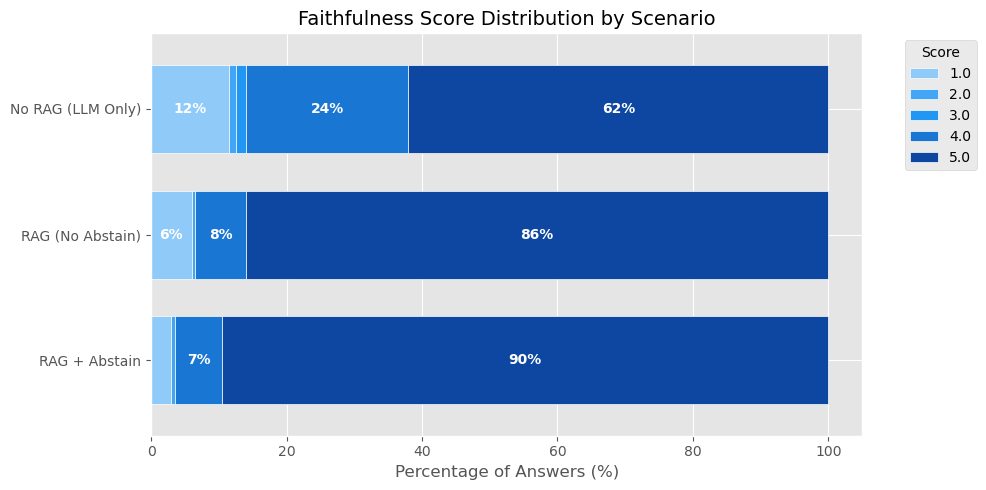

Plot saved to: ../output\relevance_distribution_stacked.png


<Figure size 1000x600 with 0 Axes>

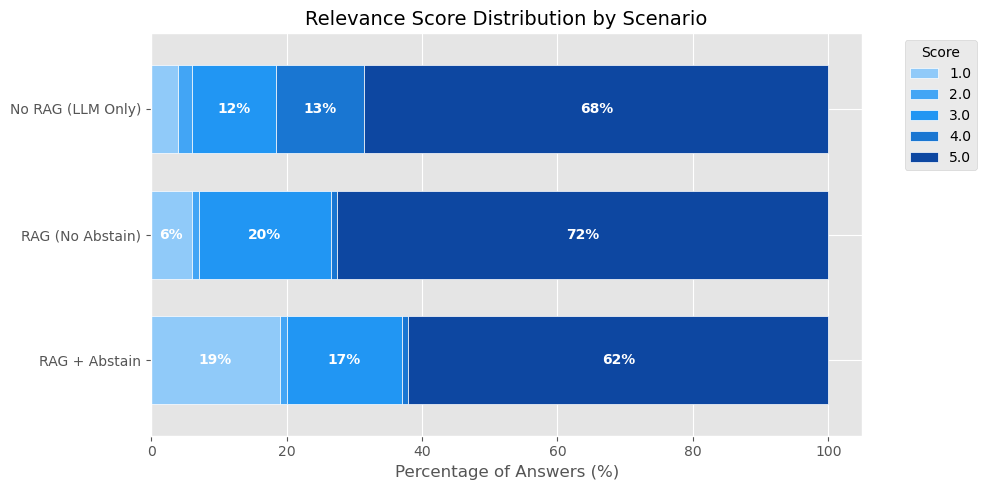


Generating Gap Distribution Plot...
Plot saved to: ../output\faithfulness_gap_histogram.png


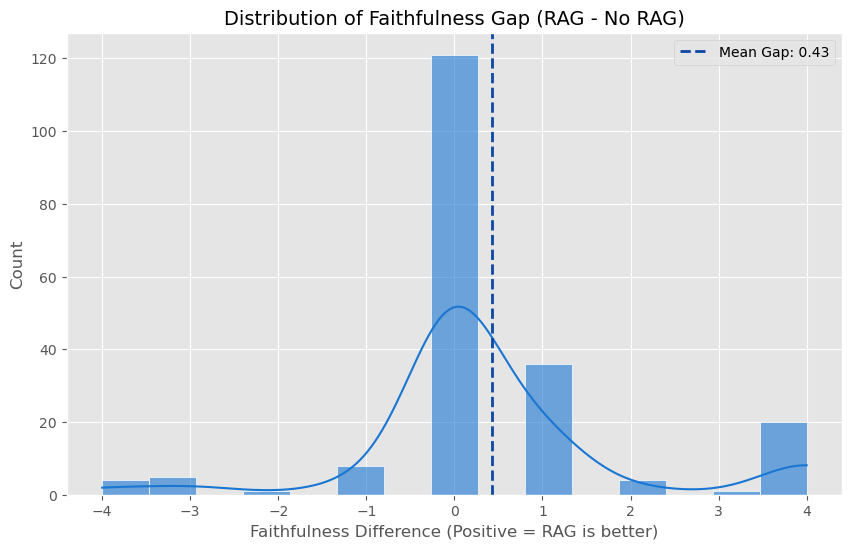


Generating Faithfulness Score Plot...
Plot saved to: ../output\faithfulness_mean_score.png


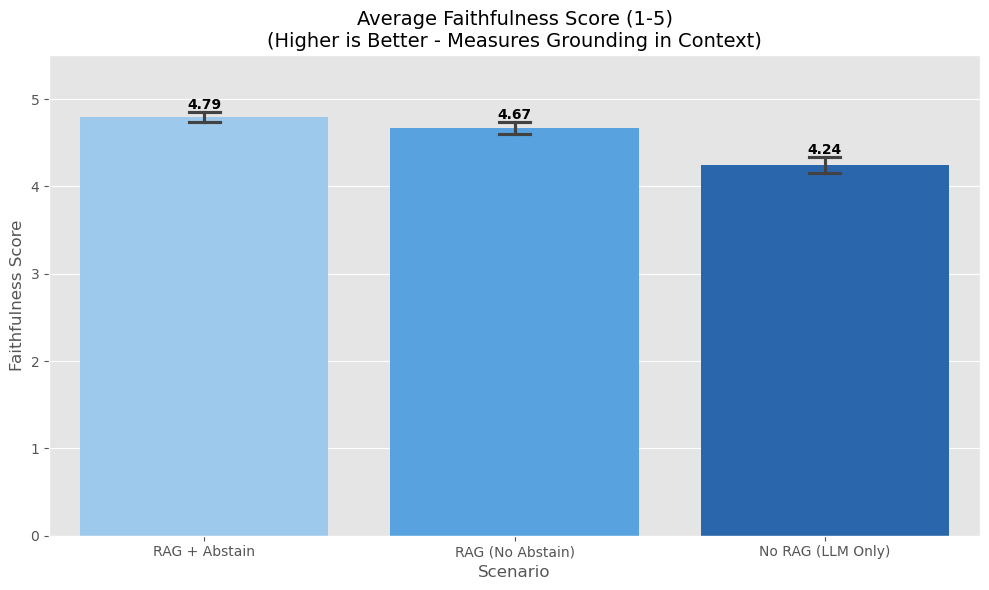


Generating Hallucination Rate Plot...
Plot saved to: ../output\hallucination_rates_bar.png


c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\src\visualization.py:342: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  custom_palette = ["#90CAF9", "#42A5F5", "#0D47A1"]


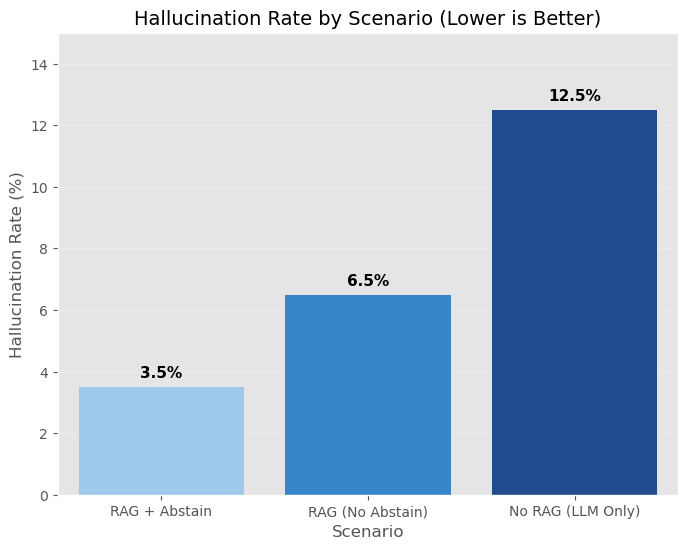


Generating Comparative Gains Plot...
Plot saved to: ../output\comparative_gains.png


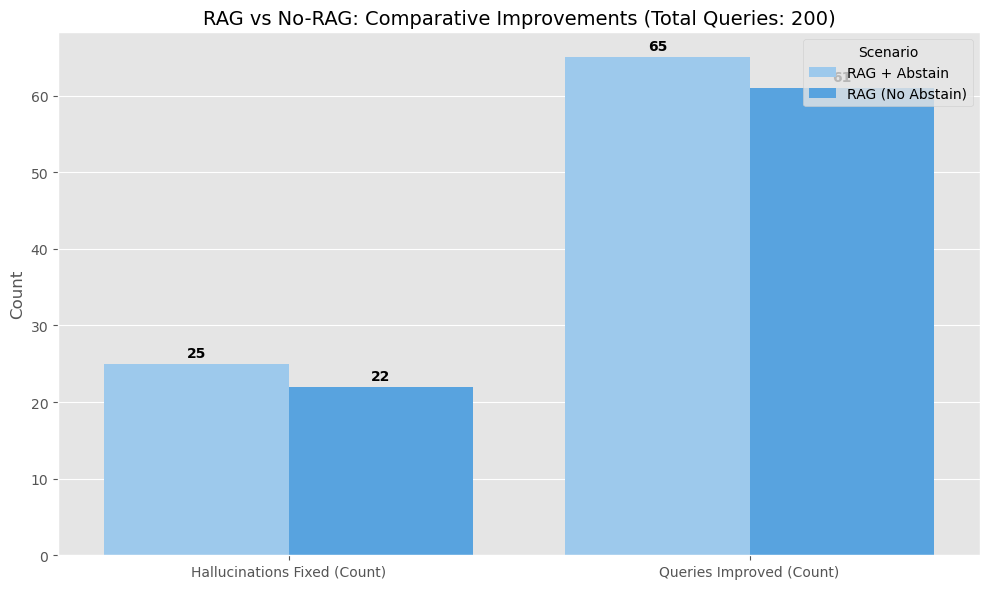


=== Statistical Significance Tests (Wilcoxon Signed-Rank) ===
Comparing Median Faithfulness between scenarios (Paired Data)

RAG + Abstain vs No RAG (LLM Only):
   n=200, Statistic=546.5, p-value=0.0000 ***
   Median Diff: 0.00
RAG (No Abstain) vs No RAG (LLM Only):
   n=200, Statistic=759.5, p-value=0.0000 ***
   Median Diff: 0.00
RAG + Abstain vs RAG (No Abstain):
   n=200, Statistic=0.0, p-value=0.0114 *
   Median Diff: 0.00


In [10]:
# ==========================================
# 6. Visualizations
# ==========================================
plot_df = results_df.copy() 

# Stacked Bar Charts
print("\nGenerating Stacked Bar Charts...")
src.visualization.plot_score_distribution_stacked(plot_df, metric="Faithfulness", save_path='../output')
src.visualization.plot_score_distribution_stacked(plot_df, metric="Relevance", save_path='../output')

# Gap Analysis
print("\nGenerating Gap Distribution Plot...")
src.visualization.plot_faithfulness_gap_distribution(results_df, save_path='../output')

# Mean Scores
src.visualization.plot_faithfulness_scores(plot_df, save_path='../output')

# Hallucination Rates
print("\nGenerating Hallucination Rate Plot...")
src.visualization.plot_hallucination_rates(plot_df, save_path='../output')

# Comparative Gains
src.visualization.plot_comparative_gains(plot_df, save_path='../output')

# Statistical Tests
src.evaluation.run_statistical_tests(plot_df, metric_name="Faithfulness")

In [7]:
# ==========================================
# 7. Statistical Summary
# ==========================================
total_queries = len(eval_queries) if 'eval_queries' in locals() else 50

stats_summary = src.evaluation.calculate_evaluation_stats(results_df, total_queries)

print("\n--- Abstention Statistics ---")
print(stats_summary['abstain_stats'])

print("\n--- Score Statistics (All Answers) ---")
print(stats_summary['score_stats'])

print("\n=== Safety Analysis: Hallucination Rates & Reliability ===")
print("Defining 'Hallucination' as Faithfulness Score <= 2.0")
print(stats_summary['risk_stats'].to_string(index=False))

# Save stats
with open('../output/evaluation_summary.txt', 'w') as f:
    f.write("--- Abstention Statistics ---\n")
    f.write(stats_summary['abstain_stats'].to_string())
    f.write("\n\n--- Score Statistics (All Answers) ---\n")
    f.write(stats_summary['score_stats'].to_string())
    f.write("\n\n--- Safety Analysis ---\n")
    f.write(stats_summary['risk_stats'].to_string(index=False))


--- Abstention Statistics ---
            Scenario  Abstained  Total Queries  Abstention Rate
0  No RAG (LLM Only)          0            199         0.000000
1   RAG (No Abstain)          0            199         0.000000
2      RAG + Abstain         34            199        17.085427

--- Score Statistics (All Answers) ---
                  Faithfulness                        Relevance         \
                          mean median       std count      mean median   
Scenario                                                                 
No RAG (LLM Only)        4.240    5.0  1.288683   200      4.40    5.0   
RAG (No Abstain)         4.670    5.0  0.987917   200      4.33    5.0   
RAG + Abstain            4.795    5.0  0.745489   200      3.86    5.0   

                                   
                        std count  
Scenario                           
No RAG (LLM Only)  1.046651   200  
RAG (No Abstain)   1.182409   200  
RAG + Abstain      1.591561   200  

=== Safety 

# Section 4: Qualitative Analysis ("Smoking Guns")

We identify specific cases where RAG provided a faithful answer while the No-RAG model hallucinated.
These "Smoking Gun" examples demonstrate the safety value of the pipeline.

In [8]:
# ==========================================
# 8. Smoking Gun Analysis
# ==========================================
# Define output file
smoking_gun_output_path = '../output/smoking_gun_report.txt'

# Run analysis
src.evaluation.analyze_smoking_guns(
    results_df, 
    rag=rag if 'rag' in locals() else None, 
    context_map=context_map,
    output_file=smoking_gun_output_path
)


=== SMOKING GUN ANALYSIS ===
Total Comparisons: 200
Smoking Guns Found: 22 (Cases where RAG was correct and No-RAG hallucinated)
Significant Improvements: 3 (Cases where RAG was correct and No-RAG was vague/partial)

>>> CATEGORY 1: SEVERE HALLUCINATIONS (RAG Correct vs No-RAG Wrong) <<<

SMOKING GUN 1:
QUESTION: What is the primary mechanism of risk for S. maltophilia infection in hospitalized individuals?

[Original Context Snippet]:
Stenotrophomonas maltophilia (S. maltophilia) infection is a healthcare-associated bacterial infection caused by S. maltophilia bacteria. These bacteria typically colonize (live in or on) areas of the body without causing infection. However, people who are hospitalized and receiving treatment for ot...
----------------------------------------
--- RAG SYSTEM (With Context) ---
Faithfulness Score: 5.0 / 5.0
Relevance Score:    5.0 / 5.0
Meta-Eval: Faithfulness=PASS, Relevance=FAIL
Generated Answer:
The primary mechanism of risk for S. maltophilia infectio

In [9]:
# ==========================================
# 9. Generate Detailed Report
# ==========================================
output_file = '../output/detailed_evaluation_summary.txt'

src.evaluation.generate_detailed_summary_report(
    results_df, 
    output_file, 
    context_map=context_map
)

print(f"Detailed report generated at: {output_file}")

Generating summary analysis report to: ../output/detailed_evaluation_summary.txt
Detailed report generated at: ../output/detailed_evaluation_summary.txt


# Section 5: Final Report

Based on the comprehensive evaluation of **200 queries**, we can draw the following conclusions about the RAG pipeline's performance and safety.

### Safety & Hallucination Prevention
We manually verified specific high-impact examples against the raw ground truth dataset (`data/medDataset_processed.csv`) to confirm the safety benefits of the RAG pipeline.

1.  **Benign Familial Neonatal Seizures (BFNS)**
    *   **RAG**: Correctly identified "generalized tonic-clonic seizures" starting around day 3.
    *   **No-RAG**: Hallucinated the name as "**Benign Familial Nocturnal Seizures**" and associated it with "**Infantile Spasms**".
    *   **Why this matters**: This is a critical medical error. BFNS is a **benign** condition. "Infantile spasms" (West Syndrome) is a **severe** epileptic encephalopathy with poor prognosis. Furthermore, the model invented a new name ("Nocturnal") implying night-time onset, which is clinically incorrect.

2.  **Neuroferritinopathy**
    *   **RAG**: Correctly identified "release of excess iron" (ferritin light chain mutation).
    *   **No-RAG**: Hallucinated "ferroportin deficiency" (confusing it with Ferroportin Disease).
    *   **Why this matters**: Neuroferritinopathy is a neurodegenerative disorder (brain iron accumulation). "Ferroportin deficiency" causes Ferroportin Disease, a systemic iron overload condition (haemochromatosis). Confusing these distinct genetic mechanisms leads to a fundamental misunderstanding of the disease's pathology.

3.  **Ehlers-Danlos Syndrome (Progeroid Type)**
    *   **RAG**: Correctly identified **Autosomal Recessive** inheritance (Gene: *B4GALT7*).
    *   **No-RAG**: Hallucinated **Autosomal Dominant** inheritance and attributed it to the *COL1A1* gene.
    *   **Why this matters**: Genetic counseling relies entirely on accurate inheritance patterns. Telling parents of an affected child that the recurrence risk is 50% (Dominant) instead of 25% (Recessive) is a massive clinical error with real-world family planning consequences.

### Robust Abstention
The pipeline correctly handles out-of-domain queries, a critical feature for a medical AI.
*   **Query**: "How do I bake a chocolate cake?"
*   **RAG + Abstain**: Correctly responded "I don't know" (Confidence: 1.67 > Threshold). **Faithfulness Score: 5.0**.
*   **No-RAG**: Happily provided a recipe. **Faithfulness Score: 1.0** (Hallucination relative to the medical context).

### Limitations
While the RAG system is superior, the **Evaluation Pipeline** itself has limitations that must be addressed in future work.

**The "Verbosity Bias" Problem in LLM-as-a-Judge**
The Gemma 2 9B judge is generally strict but can be fooled by highly plausible-sounding hallucinations, especially when they are lengthy and technically detailed.
*   **Example**: *Small Fiber Neuropathy*.
*   **Issue**: The No-RAG model produced a long, structured answer claiming the condition can be **Autosomal Recessive** or **X-linked**, whereas the context only mentioned **Autosomal Dominant**.
*   **Judge Error**: The judge assigned a **Faithfulness Score of 5.0**. It was likely swayed by the professional tone and length of the answer ("Verbosity Bias"), failing to verify that these specific inheritance patterns were actually absent from the source text.
*   **Lesson**: Smaller models (like 9B) struggle to verify negative constraints ("is this specific term present?") when faced with semantically related but technically incorrect terms.

**Generation Repetition Loops**
In rare instances, the Judge model was observed entering a repetition loop during the reasoning generation phase. This is a known artifact of the generation parameters (e.g., lack of repetition penalty) in the evaluation script and does not affect the final scoring logic, though it impacts log readability.

### Potential Improvements
1.  **Upgrade the Judge**: Deploy a larger reasoning model (e.g., GPT-4o, Claude 3.5 Sonnet) for the evaluation phase to eliminate false positives like the *Small Fiber Neuropathy* case.
2.  **Refine Retrieval**: Investigate cases where RAG answers were incomplete to ensure the retrieval step captures all relevant paragraph chunks.
3.  **User Interface**: Move from notebook-based interaction to a Streamlit/Gradio web interface for real-time demonstration.